# **Quick Demonstration of the Multi-Dimensional Conformal Prediction (Multi-Dim CP) Algorithm**


In [1]:
from utils import load_data, compute_scores, generate_Dcal_Dcells_sets, create_random_split
from multi_dim_cp import main_algo
from matplotlib import pyplot as plt
from matplotlib import colors
import numpy as np
from scipy.spatial import cKDTree
from matplotlib.patches import Patch
from utils import create_true_rest_sets
from tabulate import tabulate

np.random.seed(5)

## **Configuration Setup**
To run the multi-score method, define the following configuration parameters:

- **`DATASET_NAME`**: Identifier for the backbone's saved outputs.  
  Four `.npy` files with this name must be present in the **/output/** folder:
  - **Test outputs**: `test_outputs_{DATASET_NAME}.npy`  
    - **Shape**: `(number of backbone heads, test_size, num_labels)`
  - **Calibration outputs**: `cal_outputs_{DATASET_NAME}.npy`  
    - **Shape**: `(number of backbone heads, cal_size, num_labels)`
  - **Test targets**: `test_target_{DATASET_NAME}.npy`  
    - **Shape**: `(test_size,)`
  - **Calibration targets**: `cal_target_{DATASET_NAME}.npy`  
    - **Shape**: `(cal_size,)`

- **`ALPHA`**: Desired coverage guarantee, defined as a float in the range **[0, 1 - backbone_accuracy]**.  
  - Example: Setting `ALPHA = 0.1` ensures a **90% coverage guarantee**.

- **`b`**: Number of nearest neighbors to consider, specified as an integer **≥ 1**.  
  - Setting `b = 1` corresponds to the **multi-score method** as described in the paper.

- **`N_HEADS`**: Specifies the number of backbone heads to use in the multi-score method.  
  - Expects a **list of integers** within the range **[1, number of backbone heads]**.  
  - Example: `N_HEADS = [2, 7]` will compute results for both **2-head** and **7-head** scenarios.

- **`SCORING_METHOD`**: The nonconformity score method to be used.  
  - Acceptable values: `'RAPS'`, `'SAPS'`, `'APS'`, `'NAIVE'`  
  - While `'APS'` and `'NAIVE'` are supported, **temperature scaling** is required for stable results.  
  - For more details, refer to the paper: [LinkToPaper](https://openreview.net/pdf?id=loDppyW7e2).


In [ ]:
config={
    'DATASET_NAME': 'CIFAR100_demo', # CIFAR100_demo, PathMNIST_demo
    
    'ALPHA': 0.2, # Miscoverage rate
    
    'b': 1, # Always 1
    
    'N_HEADS': [1,2,4,7], # Number of classification head (dimension of score space)
    
    'SCORING_METHOD': 'RAPS' # RAPS, SAPS , NAIVE , APS
    
}

## **Load data**


In [3]:
cal_output,cal_target,test_output,test_target=load_data(config)


## **Run Multi-Dim CP algorithm**


In [ ]:
prediction_sets_d={}
results_table = []

for n_head in config['N_HEADS']:
    # For each number of heads, we create a random split of the calibration and test sets
    cal_output_new, cal_target_new, test_output_new, test_target_new = create_random_split(cal_output[:n_head, :, :], cal_target, test_output[:n_head, :, :], test_target)

    # Calculate scores
    cal_scores = compute_scores(cal_output_new,config)
    test_scores = compute_scores(test_output_new,config)

    # Split claibration into cells set (Dcells) and re-calibration set (Dre_cal)
    Dcells_scores, Dcells_target, Dre_cal_scores, Dre_cal_target = generate_Dcal_Dcells_sets(cal_scores, cal_target_new)

    # Run the main algorithm
    # The main_algo function returns:
    #   coverage = empirical coverage on the test set
    #   mean_set = mean predicted set size on the test set
    #   prediction_sets_new_meth = the actual prediction sets on the test set, as a boolean array (n_test,n_classes)
    #   wanted_centers = indices of the selected cells centers (in cal_true_preds_with_zero)
    #   cal_true_preds_with_zero = The centers of the cells (which are the scores of the true labels in Dcells_scores)
    coverage, mean_set, prediction_sets_new_meth, (wanted_centers, cal_true_preds_with_zero) = main_algo(Dcells_scores,
                                                                                                         Dcells_target,
                                                                                                         Dre_cal_scores,
                                                                                                         Dre_cal_target,
                                                                                                         test_scores,
                                                                                                         test_target_new,
                                                                                                         config['ALPHA'],
                                                                                                         config)

    prediction_sets_d[n_head]=prediction_sets_new_meth

    if n_head==2:
        # Prepare for plotting
        test = create_true_rest_sets(test_scores,test_target_new,'CAL')
        args_for_selected_cells_plot=[cal_true_preds_with_zero, wanted_centers, test]

    results_table.append([
        n_head,                 # N_HEAD
        round(coverage,3),      # Coverage archived
        1 - config['ALPHA'],    # Coverage wanted
        round(mean_set, 3)      # Mean Predicted Set Size
    ])

headers = ["N_HEAD", "Coverage archived", "Coverage wanted", "Mean-Predicted-Set-Size"]
print(tabulate(results_table, headers=headers, tablefmt="pretty"))



[]
[]
[]
[]
+--------+-------------------+-----------------+-------------------------+
| N_HEAD | Coverage archived | Coverage wanted | Mean-Predicted-Set-Size |
+--------+-------------------+-----------------+-------------------------+
|   1    |       0.806       |       0.8       |         12.165          |
|   2    |       0.802       |       0.8       |          4.617          |
|   4    |       0.798       |       0.8       |          2.712          |
|   7    |       0.801       |       0.8       |          2.395          |
+--------+-------------------+-----------------+-------------------------+


## **Plot Set-Size Distribution for Increasing Score Dimensions**
In this section, we illustrate how increasing the number of heads in the **Multi-Dimensional Conformal Prediction (Multi-Dim CP)** algorithm leads to **smaller** and **more informative** predicted sets.
As the number of heads increases, both the **center** and the **right tail** of the set-size distribution shift towards smaller values.

By leveraging multiple backbone heads, the model effectively refines its predictions, improving efficiency while maintaining conformal coverage guarantees.



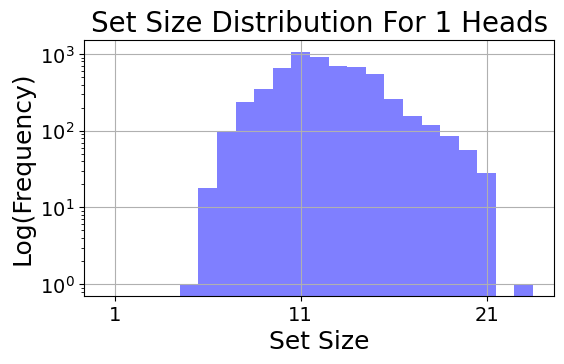

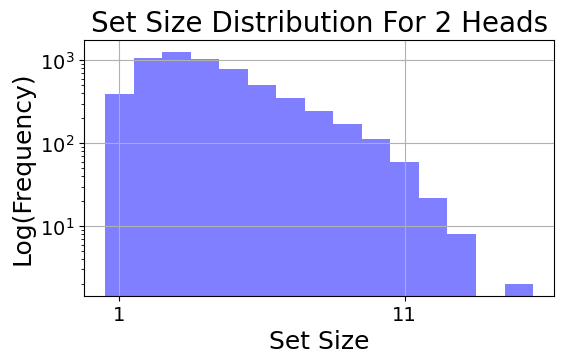

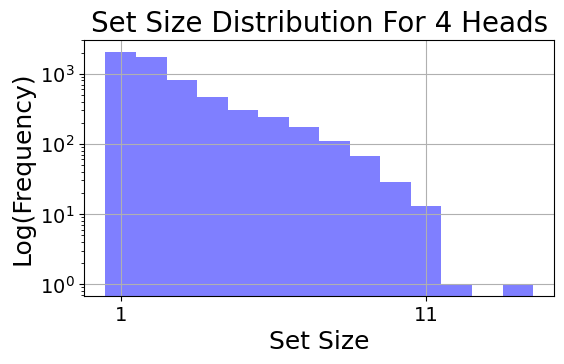

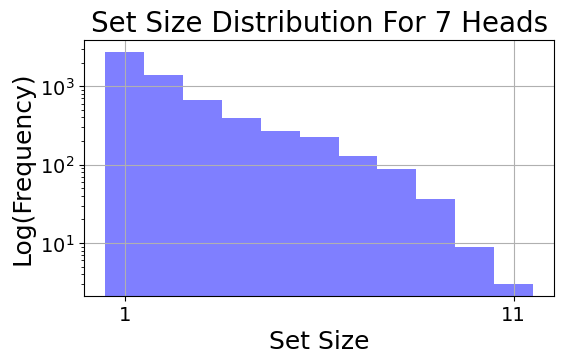

In [ ]:
# Plots a histogram of set sizes per # of heads
def plot_set_size_per_head_comb(prediction_sets_d):
    for k,v in prediction_sets_d.items() :
        vec = v.sum(axis=1)
        bins = range(1, int(max(vec) + 2))
        plt.figure(figsize=(6, 4))
        plt.hist(vec, bins=bins, color='blue', alpha=0.5, align='left')
        plt.yscale('log')
        plt.xlabel("Set Size", fontsize=18)
        plt.ylabel('Log(Frequency)', fontsize=18)
        plt.title(f"Set Size Distribution For {k} Heads", fontsize=20)
        plt.grid(True)
        xticks_spacing = max(1, v.shape[1] // 10)
        plt.xticks(bins[::xticks_spacing], fontsize=14)
        plt.yticks(fontsize=14)
        plt.tight_layout(pad=2.0)
        plt.show()
        

plot_set_size_per_head_comb(prediction_sets_d)


## **Plot 2D Cell Selection Map**
In this section, we visualize the **2D cell selection map** of the algorithm along with its test (unseen) scores.

### **Legend:**
- **Blue areas** represent the **selected cells**.
- **Red areas** indicate the **unselected cells**.
- **White dots** mark the **true test scores**.
- **Pink Xs** indicate the **false test scores**.

As observed, the **selected cells** successfully cover **(1 - α)%** of the **true test scores**, while effectively avoiding regions with a **high concentration of false test scores**.



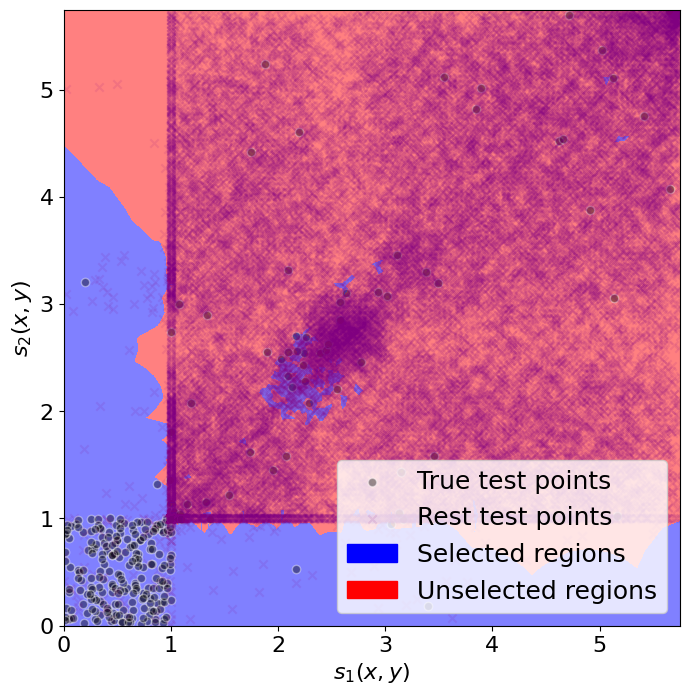

In [ ]:
# Plots the 2D score space for 2 heads. 
def plot_selected_cells2(centers_unique,
                         wanted_centers_idx,
                         tests,
                         num_dp=300,
                         grid_resolution=5000):
    axis_max = max(np.max(centers_unique, axis=1)[0], np.max(centers_unique, axis=1)[1])
    x_min, x_max = 0, axis_max
    y_min, y_max = 0, axis_max
    x = np.linspace(x_min, x_max, grid_resolution)
    y = np.linspace(y_min, y_max, grid_resolution)
    xx, yy = np.meshgrid(x, y)
    grid_points = np.c_[xx.ravel(), yy.ravel()]
    tree = cKDTree(centers_unique.T)
    closest_idx = tree.query(grid_points,k=config['b'])[1]
    scores_in = np.isin(closest_idx, wanted_centers_idx)
    scores_in = np.expand_dims(scores_in, axis=1) if scores_in.ndim == 1 else scores_in
    is_closest_wanted_grid = (scores_in.sum(axis=1) >= max(config['b'] * 0.5, 1)).reshape(grid_resolution, grid_resolution)
    cmap = colors.ListedColormap(['red', 'blue'])
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.imshow(is_closest_wanted_grid, extent=(x_min, x_max, y_min, y_max), origin='lower', cmap=cmap, zorder=-1, alpha=0.5)
    ax.scatter(tests[0][0, :num_dp], tests[0][1, :num_dp], color='k', edgecolors='white', alpha=0.4, zorder=1,
               label='True test points')
    ax.scatter(tests[1][0, :num_dp].reshape(-1), tests[1][1, :num_dp].reshape(-1), color='purple', marker='x', alpha=0.1,
               label='Rest test points')
    ax.set_xlabel(r'$s_1(x,y)$', fontsize=16)
    ax.set_ylabel(r'$s_2(x,y)$', fontsize=16)
    ax.tick_params(axis='both', which='major', labelsize=16)
    legend_patches = [
        Patch(color='blue', label='Selected regions'),
        Patch(color='red', label='Unselected regions')
    ]
    handles, labels = ax.get_legend_handles_labels()
    handles.extend(legend_patches)
    ax.legend(handles=handles, loc='lower right', fontsize=18)
    plt.xlim(0, axis_max)
    plt.ylim(0, axis_max)
    plt.show()

if 2 in config['N_HEADS']:
    plot_selected_cells2(*args_for_selected_cells_plot)